<a href="https://colab.research.google.com/github/rukaiyafahmida/SoftComputing/blob/main/Assignment_02_170204004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import seaborn as sns
import pandas as pd
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/4.2 Rukaiya/Dataset.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


#Preprossesing

In [7]:
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import re 
import string
import pickle
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

seed = 4
torch.manual_seed(seed)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
def cleaner(text):
    text = text.lower()
    text=text[1:] 
    text = re.sub(urlPattern,'',text)
    text = text.translate(str.maketrans("","",string.punctuation))
    tokens = word_tokenize(text)
    final_tokens = [w for w in tokens if w not in stop_words]
    wordLemm = WordNetLemmatizer()
    final_words=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        final_words.append(word)
    return ' '.join(final_words)   

In [9]:
df['final_text'] = df['Text'].apply(lambda x: cleaner(x))

In [10]:
df["Sentiment"] = df["Sentiment"].replace(-1,0)
df["Sentiment"].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

In [11]:
df = df.sample(frac = 1) 
df

,Text,Sentiment,final_text
4352,more bad AAP news they might ONY SE 43B not pr...,1,ore bad aap news might ony se 43b projected 43...
1854,"NFX new HoD, nice",1,fx new hod nice
4587,AMTD Come on give it up.,0,mtd come give
2653,"The first target for NEM below 43 is 40, but t...",0,first target nem 43 40 room bigger move 28 val...
2752,GOOG Glass is coool,1,oog glass coool
...,...,...,...
5075,â€˜Amid coronavirus-related upheaval to the ca...,1,€˜amid coronavirusrelated upheaval car industr...
4529,ACAD taking more off here,1,cad taking
4830,HAO like it on a pop over 6 w vol,1,ao like pop vol
280,CEG possible ONG today if you want to play the...,1,eg possible ong today want play jpmogan biotec...


In [12]:
from sklearn.model_selection import train_test_split
x = df['final_text'].values
y = df['Sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [13]:
df.head()

,Text,Sentiment,final_text
4352,more bad AAP news they might ONY SE 43B not pr...,1,ore bad aap news might ony se 43b projected 43...
1854,"NFX new HoD, nice",1,fx new hod nice
4587,AMTD Come on give it up.,0,mtd come give
2653,"The first target for NEM below 43 is 40, but t...",0,first target nem 43 40 room bigger move 28 val...
2752,GOOG Glass is coool,1,oog glass coool


# One hot embedding

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [15]:
 from keras.preprocessing.text import Tokenizer
 tokenizer = Tokenizer()
 tokenizer.fit_on_texts(x_train)
 X_train = tokenizer.texts_to_sequences(x_train)
 X_test = tokenizer.texts_to_sequences(x_test)
 vocab_size = len(tokenizer.word_index)+1

In [16]:
 print(x_train[1])
 print(X_train[1]) 

ensex nifty extend loss second day amid rising coronavirus case
[55, 43, 705, 119, 316, 7, 67, 451, 37, 772]


In [17]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [18]:
 from keras.preprocessing.sequence import pad_sequences
 maxlen = 1000
 X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
 X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [19]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalMaxPooling1D
from keras import layers 
import tensorflow as tf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 200)         1869200   
                                                                 
 conv1d (Conv1D)             (None, 999, 256)          102656    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 128)          98432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 128)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 245, 64)           3

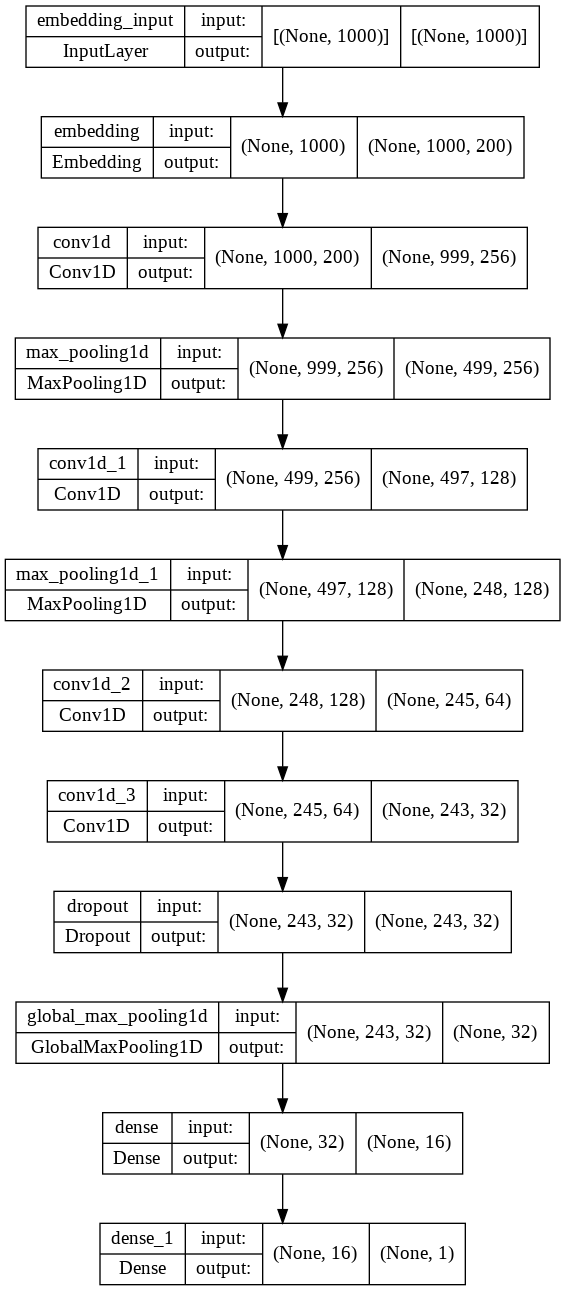

In [20]:
seed = 4
torch.manual_seed(seed)
embedding_dim = 200
cnnmodel = Sequential()
cnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
cnnmodel.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
cnnmodel.add(layers.MaxPooling1D(pool_size = 2))
cnnmodel.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
cnnmodel.add(layers.MaxPooling1D(pool_size = 2))
cnnmodel.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
cnnmodel.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
cnnmodel.add(layers.Dropout(0.2))
cnnmodel.add(layers.GlobalMaxPooling1D())
cnnmodel.add(layers.Dense(16, activation='relu'))
cnnmodel.add(layers.Dense(1, activation='sigmoid'))
cnnmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])
cnnmodel.summary() 

tf.keras.utils.plot_model(cnnmodel, show_shapes = True, show_layer_names = True)


In [21]:
history = cnnmodel.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)

loss, accuracy, f1_score, precision, recall = cnnmodel.evaluate(X_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, oheaccuracy, f1_score, precision, recall = cnnmodel.evaluate(X_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)



Epoch 1/10
145/145 [==============================] - 20s 52ms/step - loss: 0.6112 - accuracy: 0.6587 - f1_m: 0.7721 - precision_m: 0.6685 - recall_m: 0.9401 - val_loss: 0.5116 - val_accuracy: 0.7403 - val_f1_m: 0.7743 - val_precision_m: 0.8105 - val_recall_m: 0.7489
Epoch 2/10
145/145 [==============================] - 7s 47ms/step - loss: 0.3563 - accuracy: 0.8480 - f1_m: 0.8771 - precision_m: 0.8869 - recall_m: 0.8754 - val_loss: 0.4691 - val_accuracy: 0.7774 - val_f1_m: 0.8179 - val_precision_m: 0.8020 - val_recall_m: 0.8441
Epoch 3/10
145/145 [==============================] - 7s 47ms/step - loss: 0.1369 - accuracy: 0.9510 - f1_m: 0.9609 - precision_m: 0.9653 - recall_m: 0.9586 - val_loss: 0.5980 - val_accuracy: 0.7705 - val_f1_m: 0.8190 - val_precision_m: 0.7827 - val_recall_m: 0.8652
Epoch 4/10
145/145 [==============================] - 7s 50ms/step - loss: 0.0494 - accuracy: 0.9838 - f1_m: 0.9870 - precision_m: 0.9857 - recall_m: 0.9889 - val_loss: 0.8648 - val_accuracy: 0.7705

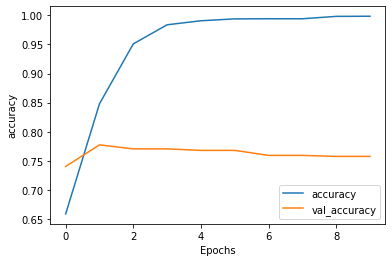

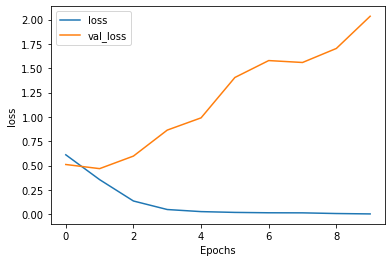

In [22]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Bag Of Words

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)


from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

vectorizer.fit(x)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


In [24]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [25]:
print('Total training data: ', X_train.shape[0])
print('Total testing data:  ', X_test.shape[0])

Total training data:  4632
Total testing data:   1159


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               2706944   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)               

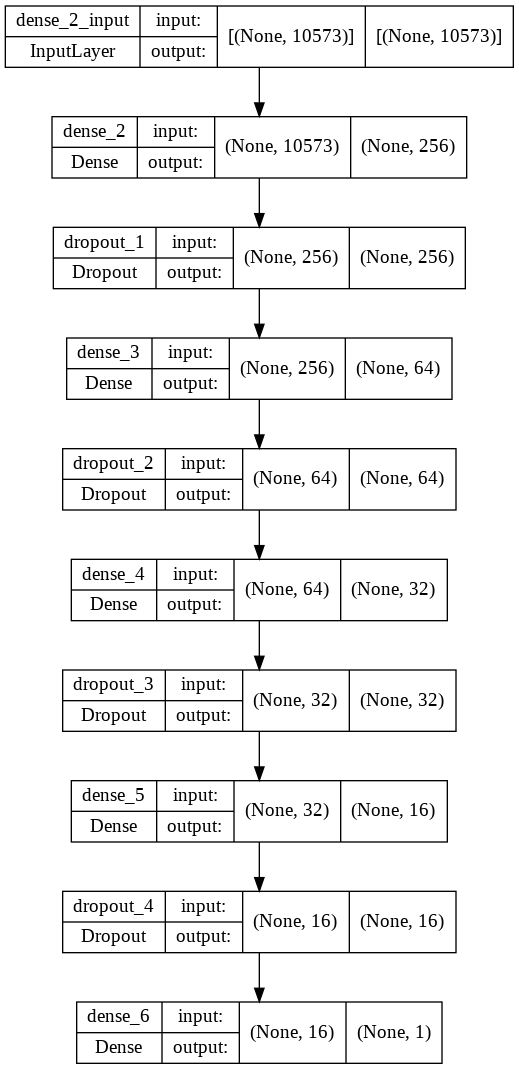

In [26]:
bogmodel = Sequential()
bogmodel.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names_out())))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=64, activation='relu'))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=32, activation='relu'))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=16, activation='relu'))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=1, activation='sigmoid'))

bogmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])
bogmodel.summary() 

tf.keras.utils.plot_model(bogmodel, show_shapes = True, show_layer_names = True)


In [34]:
history = bogmodel.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)

loss, accuracy, f1_score, precision, recall = bogmodel.evaluate(X_train, y_train)
print("Training Accuracy: {}".format(accuracy))

loss, bogaccuracy, f1_score, precision, recall = bogmodel.evaluate(X_test, y_test)
print("Testing Accuracy: ".format(accuracy))
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)



Epoch 1/10
145/145 [==============================] - 1s 10ms/step - loss: 9.7938e-04 - accuracy: 0.9994 - f1_m: 0.9995 - precision_m: 0.9993 - recall_m: 0.9997 - val_loss: 2.8716 - val_accuracy: 0.7515 - val_f1_m: 0.8099 - val_precision_m: 0.8028 - val_recall_m: 0.8245
Epoch 2/10
145/145 [==============================] - 1s 10ms/step - loss: 9.2740e-04 - accuracy: 0.9998 - f1_m: 0.9998 - precision_m: 0.9996 - recall_m: 1.0000 - val_loss: 2.9953 - val_accuracy: 0.7394 - val_f1_m: 0.7972 - val_precision_m: 0.8025 - val_recall_m: 0.7998
Epoch 3/10
145/145 [==============================] - 2s 14ms/step - loss: 0.0010 - accuracy: 0.9994 - f1_m: 0.9995 - precision_m: 0.9993 - recall_m: 0.9997 - val_loss: 3.0942 - val_accuracy: 0.7455 - val_f1_m: 0.8040 - val_precision_m: 0.8020 - val_recall_m: 0.8138
Epoch 4/10
145/145 [==============================] - 2s 14ms/step - loss: 0.0012 - accuracy: 0.9994 - f1_m: 0.9996 - precision_m: 0.9997 - recall_m: 0.9994 - val_loss: 3.1730 - val_accuracy:

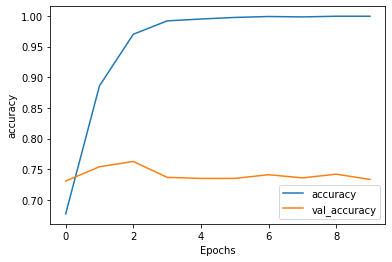

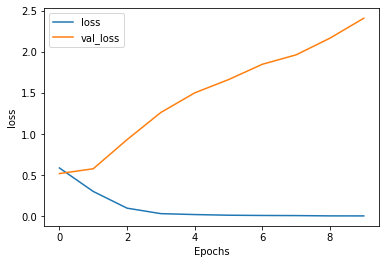

In [28]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# TF-IDF

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)


from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')

vectorizer.fit(x)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


In [30]:
X_train = X_train.toarray()
X_test = X_test.toarray()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               2706944   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)               

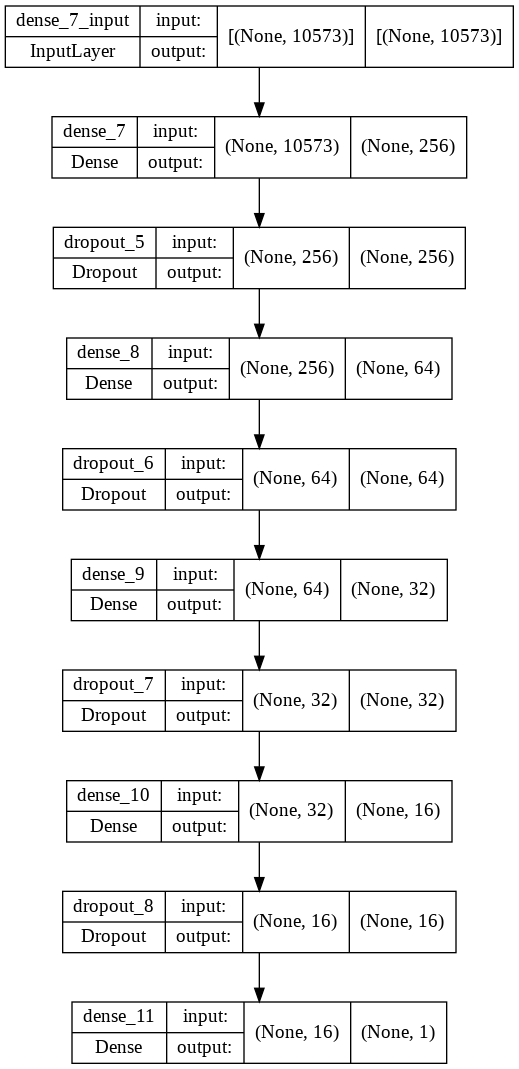

In [31]:
tfmodel = Sequential()
tfmodel.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names_out())))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=64, activation='relu'))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=32, activation='relu'))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=16, activation='relu'))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=1, activation='sigmoid'))

tfmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])
tfmodel.summary() 

tf.keras.utils.plot_model(tfmodel, show_shapes = True, show_layer_names = True)


In [32]:
history = tfmodel.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)

loss, accuracy, f1_score, precision, recall = tfmodel.evaluate(X_train, y_train)
print("Training Accuracy: {}".format(accuracy))

loss, tfaccuracy, f1_score, precision, recall = tfmodel.evaluate(X_test, y_test)
print("Testing Accuracy:  {}".format(accuracy))
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)



Epoch 1/10
145/145 [==============================] - 3s 12ms/step - loss: 0.5961 - accuracy: 0.6740 - f1_m: 0.7758 - precision_m: 0.6862 - recall_m: 0.9220 - val_loss: 0.5148 - val_accuracy: 0.7481 - val_f1_m: 0.8080 - val_precision_m: 0.7934 - val_recall_m: 0.8294
Epoch 2/10
145/145 [==============================] - 1s 9ms/step - loss: 0.3093 - accuracy: 0.8810 - f1_m: 0.9038 - precision_m: 0.9041 - recall_m: 0.9090 - val_loss: 0.5866 - val_accuracy: 0.7463 - val_f1_m: 0.8160 - val_precision_m: 0.7777 - val_recall_m: 0.8629
Epoch 3/10
145/145 [==============================] - 1s 9ms/step - loss: 0.0995 - accuracy: 0.9683 - f1_m: 0.9738 - precision_m: 0.9738 - recall_m: 0.9752 - val_loss: 0.9139 - val_accuracy: 0.7524 - val_f1_m: 0.8114 - val_precision_m: 0.7964 - val_recall_m: 0.8343
Epoch 4/10
145/145 [==============================] - 1s 9ms/step - loss: 0.0354 - accuracy: 0.9896 - f1_m: 0.9915 - precision_m: 0.9919 - recall_m: 0.9916 - val_loss: 1.2524 - val_accuracy: 0.7377 - v

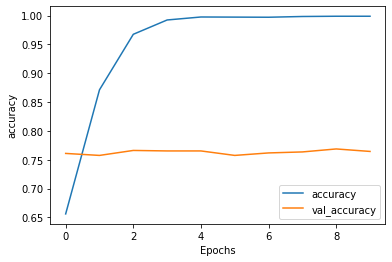

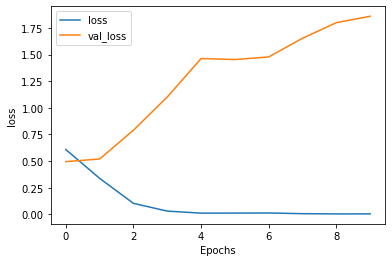

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

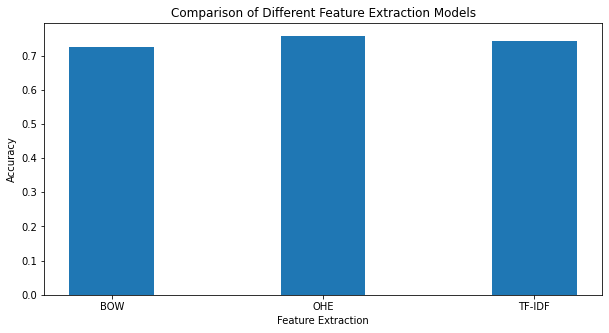

In [35]:
data = {'BOW':bogaccuracy, 'OHE':oheaccuracy, 'TF-IDF':tfaccuracy}
tech = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(tech, values, width = 0.4)
 
plt.xlabel("Feature Extraction")
plt.ylabel("Accuracy")
plt.title("Comparison of Different Feature Extraction Models")
plt.show()